# Maximum likelihood estimation for RNA count model

## kinetic-sequencing results model
Given an RNA pool that has dynamic composition follows individual kinetic models, infer the initial pool composition `p0`, and kinetic coefficient `k` and `a` defined in the model for each RNA sequence

- first-order kinetic model

$$
\mathbf{p}_t = \mathbf{p}_0 \odot \mathbf{a}_0 \odot (1 - \exp(-\alpha t \mathbf{k} \times \mathbf{c}))
$$

- count-model, Multinomial($\mathbf{p}_j$, $n_j$)
$$
p(n_{j1}, n_{j2}, \dots, n_{jm} | \mathbf{p}_j) = n_j! \prod_{i=1}^m \frac{p_{ji}^{n_{ji}}}{n_{ji}!}
$$
where $\sum_{i=1}^m p_i = 1$, $\sum_{i=1}^m n_{ji} = n_j$

Thus the equivalent log-likelihood function to maximize could be written as:

$$
\mathcal{l}(\mathbf{p}_0, \mathbf{a}, \mathbf{k}|\mathbf{N}, \mathbf{c}) = \sum_{j=1}^J \sum_{i=1}^m n_{ji}\log (p_ji)
$$
where

$$
\mathcal{l}(\mathbf{p}_0, \mathbf{a}, \mathbf{k}|\mathbf{N}, \mathbf{c}) = \sum_{j=1}^J \sum_{i=1}^m \mathbb{I}_{c_j = 0} n_{ji}\log (p_{0i}) + \mathbb{I}_{c_j\not = 0} n_{ji}\large[ \log(p_{0i}) + \log(a_i) + \log((1 - \exp(-\alpha t k_{ji} c_{j}))) - \log(\sum_{q=1}^m p_{0q}a_{q}(1 - \exp(-\alpha t k_{q} c_j)))\large]
$$


The easy version we are trying to optimize is

$$
\mathcal{l}(\mathbf{p}_0, \mathbf{a}, \mathbf{k}|\mathbf{N}, \mathbf{c}) = \sum_{j=1}^J \sum_{i=1}^m \mathbb{I}_{c_j = 0} n_{ji}\log (p_{0i}) + \mathbb{I}_{c_j\not = 0} n_{ji}[ \log(p_{0i}) + \log(a_i) + \log((1 - \exp(-\alpha t k_{ji} c_{j})))
$$

which the normalization term for probability is removed

In [1]:
import cvxpy as cp
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from yuning_util.dev_mode import DevMode
dev_mode = DevMode(pkg='k-seq')
dev_mode.on()
from k_seq.utility import file_tools, log
from importlib import reload
reload(file_tools)
reload(log)

<module 'k_seq.utility.log' from '/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/k_seq/utility/log.py'>

In [4]:
from k_seq.data import seq_table
form k_seq.data import count_data
byo_doped = seq_table.SeqTable.load_default_dataset(dataset='byo-doped')

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo_doped.pkl
Imported!


In [33]:
data = count_data.CountData.from_simu_path(path='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_shallow/', )

In [57]:
data.ctrl_vars_input.shape[1]

3

## convex Model

In [37]:
def get_convex_model(data):
    """Data is the CountData"""

    # Variables.
    seq_num, sample_num = data.count.shape
    p0 = cp.Variable((seq_num))
    a = cp.Variable((seq_num))
    k = cp.Variable((seq_num))
    t = 90
    alpha = 0.476

    # LL matrix
    # LL for initial pool
    # n_ij \log p_i0 for any j in initial pool
    ll_init = cp.sum(
        cp.multiply(data.count_input.values.T,
                    cp.log(cp.vstack([p0 for _ in range(data.count_input.shape[1])])))
    )
    ## LL for reacted pool
    # n_ij (\log p_i0 + \log a_i + \log (1 - exp(-alpha * t * k_i * c_js )))
    ll_reacted = cp.sum(
        cp.multiply(
            data.count_reacted.values.T,
            cp.vstack([(cp.log(p0) + cp.log(a)) for _ in range(data.ctrl_vars_reacted.shape[1])]) \
            + cp.log(1 - cp.exp(- alpha * t * cp.vstack([c * k for c in data.ctrl_vars_reacted.loc['c'].values])))
        )
    )
    
    # Convex neg-likelihood function
    nll = -ll_init - ll_reacted
    objective = cp.Minimize(nll)

    # Constraints.
    constraints = (
        [0 <= p0,
         cp.sum(p0) == 1,
         a >= 0,
         a <= 1,
         k >= 0]
    )

    # Problem.
    prob = cp.Problem(objective, constraints)
    
    from collections import namedtuple
    Params = namedtuple(field_names=['p0', 'a', 'k'], typename='params')
    
    return prob, Params(p0=p0, a=a, k=k)

def run_solver(prob, solver=cp.SCS, verbose=True, log_dir=None):
    from k_seq.utility.log import Timer, FileLogger
    
    if log_dir is not None:
        with FileLogger(file_path=log_dir), Timer():
            solution = prob.solve(solver, verbose=verbose)
    else:
        with Timer():
            solution = prob.solve(solver, verbose=verbose)
            
def main(output_dir, seq_table=None, table_name=None, input_pools=None,
         simu_data_path=None, solver='SCS', notes=None):
    
    from k_seq.utility.file_tools import dump_pickle
    import cvxpy as cp
    from pathlib import Path
    
    if seq_table is not None:
        count_data = CountData.from_SeqTable(seq_table=seq_table, table_name=table_name,
                                             input_pools=input_pools, note=notes)
    elif simu_data_path is not None:
        count_data = CountData.from_simu_path(path=simu_data_path, input_pools=input_pools, note=notes)
    
    prob, params = get_convex_model(count_data)
    print(f'Problem created, start solving with {solver}')
    
    if isinstance(solver, str):
        if solver.upper() == 'SCS':
            solver = cp.SCS
        if solver.upper() == 'MOSEK':
            solver = cp.MOSEK
        
    if not Path(output_dir).exists():
        Path(output_dir).mkdir(parents=True)

    run_solver(prob=prob, solver=solver, verbose=True, log_dir=output_dir + '/solver.log')
    print('Problem solving finished. Status unknown')
    dump_pickle(prob, path=output_dir + '/problem.pkl')
    dump_pickle(pd.DataFrame({'a': params.a.value, 'k': params.k.value, 'p0': params.p0.value}),
                path=output_dir + '/parameters.pkl')
    print(f'Running results saved to {output_dir}')

def compare_to_truth(data, params, **kwargs):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')
    fig, axes = plt.subplots(1, 4, figsize=[16, 4])
    
    def scale_free_plot(x, y, ax, log=False, label=None, **kwargs):
        from scipy import stats
        
        x_lim = np.min(x) * 0.9, np.max(x) * 1.1
        y_lim = np.min(y) * 0.9, np.max(y) * 1.1
        ax.scatter(x, y, **kwargs)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        if log:
            ax.set_xscale('log')
            ax.set_yscale('log')
        ax.set_title(f"Pearson: {stats.pearsonr(x, y)[0]:.4f}\nSpearman: {stats.spearmanr(x, y)[0]:.4f}")
        ax.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
        if label is not None:
            ax.set_xlabel(label, fontsize=12)
    
    scale_free_plot(x=data.truth['p0'], y=params.p0.value, ax=axes[0], log=True, label='p0', **kwargs)
    scale_free_plot(x=data.truth['a'], y=params.a.value, ax=axes[1], log=False, label='a', **kwargs)
    scale_free_plot(x=data.truth['k'], y=params.k.value, ax=axes[2], log=True, label='k',**kwargs)
    scale_free_plot(x=data.truth['k'] * data.truth['a'], 
                    y=params.a.value * params.k.value,
                    ax=axes[3], log=True, label='a*k', **kwargs)
    plt.show()

In [38]:
params = main(simu_data_path='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_deep/',
     output_dir='/mnt/storage/projects/k-seq/working/count_model_mle/dist_small_even_deep_scs/', solver='MOSEk')

In [25]:
import pickle

with open('/mnt/storage/projects/k-seq/test.pkl', 'wb') as handle:
    pickle.dump(params.a, handle)

<bound method Variable.variables of Variable((1000,))>

In [73]:
with Timer():
    prob = get_convex_model(data)
    solution = prob.solve(cp.SCS, verbose=True)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 131000
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 66000, constraints m = 193001
Cones:	primal zero / dual free vars: 1
	linear vars: 4000
	exp vars: 189000, dual exp vars: 0
Setup time: 4.66e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.36e+21  3.67e+22  1.00e+00 -6.41e+28  1.60e+29  1.38e+29  8.05e-01 
   100| 1.76e-01  1.55e-01  4.50e-03  1.05e+07  1.06e+07  1.34e-08  5.80e+01 
   200| 2.36e-01  3.04e-01  1.71e-02  9.72e+06  

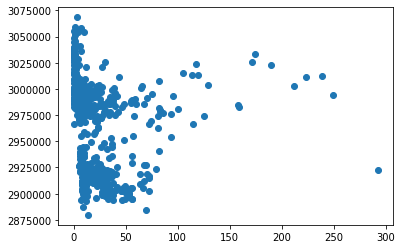

In [72]:
print()
import matplotlib.pyplot as plt

plt.scatter(data.truth['k'], k.value);

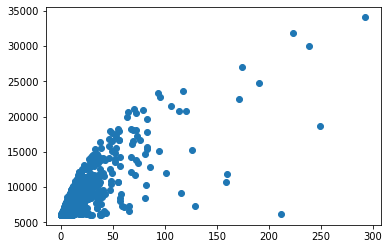

In [80]:
print()
import matplotlib.pyplot as plt

plt.scatter(data.truth['k'], k.value);
from scipy import stats

stats.pearsonr(x=data.truth['k'], y=k.value)

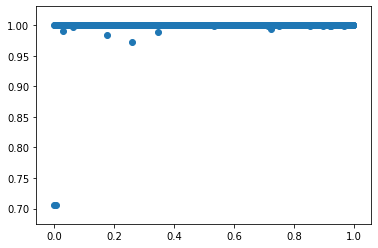

In [81]:
print()
import matplotlib.pyplot as plt

plt.scatter(data.truth['a'], a.value);

### Only top seqs

In [285]:
data_10 = data.select(n=10, shuffle=True)
prob_10, param_10 = get_convex_model(data=data_10)

In [286]:
run_solver(prob=prob_10)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1310
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 660, constraints m = 1931
Cones:	primal zero / dual free vars: 1
	linear vars: 40
	exp vars: 1890, dual exp vars: 0
Setup time: 3.91e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.17e+20  3.68e+21  1.00e+00 -3.51e+25  8.69e+25  7.54e+25  1.07e-02 
   100| 4.06e-02  1.03e-01  6.31e-03  4.73e+04  4.79e+04  1.28e-11  5.42e-01 
   200| 6.55e-02  1.62e-01  4.04e-03  4.32e+04  4.35e+04  

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

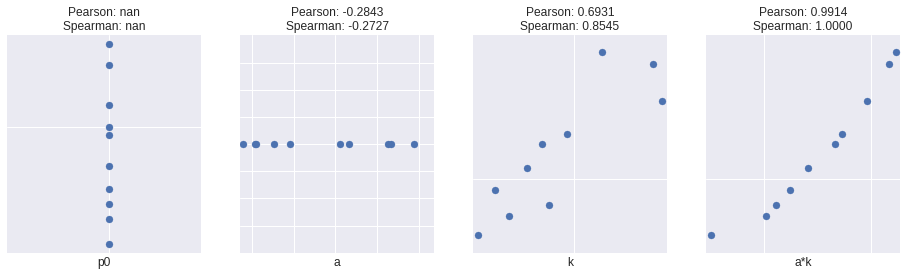

In [287]:
compare_to_truth(data_10, param_10)

#### USE Mosek

In [289]:
data_10 = data.select(n=10, shuffle=True)
prob_10_mosek, param_10_mosek = get_convex_model(data=data_10)
run_solver(prob=prob_10_mosek, solver=cp.MOSEK)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1931            
  Cones                  : 630             
  Scalar variables       : 2550            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1931            
  Cones                  : 630             
  Scalar variables       : 2550            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 180
Optimizer  - Cones                  : 631
Optimizer  - Scalar variabl

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

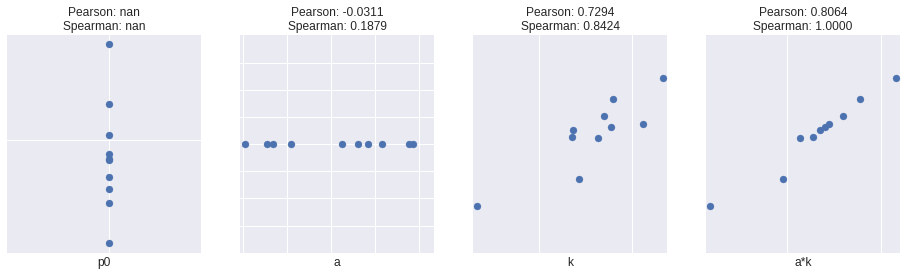

In [290]:
compare_to_truth(data_10, param_10_mosek)

### Size 100 simu model

In [267]:
data_100 = data.select(n=100, shuffle=True)
prob_100, param_100 = get_convex_model(data=data_100)

In [268]:
run_solver(prob=prob_100)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 13100
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 6600, constraints m = 19301
Cones:	primal zero / dual free vars: 1
	linear vars: 400
	exp vars: 18900, dual exp vars: 0
Setup time: 7.26e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.00e+21  1.16e+22  1.00e+00 -2.04e+27  5.09e+27  4.39e+27  8.28e-02 
   100| 2.34e-01  3.10e-01  2.14e-02  9.44e+05  9.86e+05  1.41e-11  5.66e+00 
   200| 4.29e-01  2.56e-01  5.89e-03  9.23e+05  9.12e

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

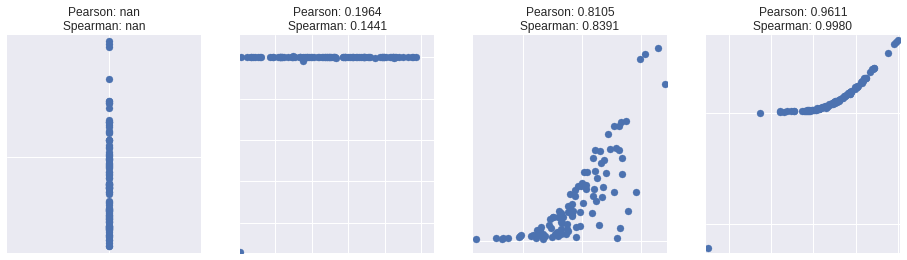

In [279]:
compare_to_truth(data_100, param_100)

In [280]:
prob_100_mosek, param_100_mosek = get_convex_model(data=data_100)
run_solver(prob=prob_100_mosek, solver=cp.MOSEK)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 19301           
  Cones                  : 6300            
  Scalar variables       : 25500           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 19301           
  Cones                  : 6300            
  Scalar variables       : 25500           
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 1800
Optimizer  - Cones                  : 6301
Optimizer  - Scalar varia

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

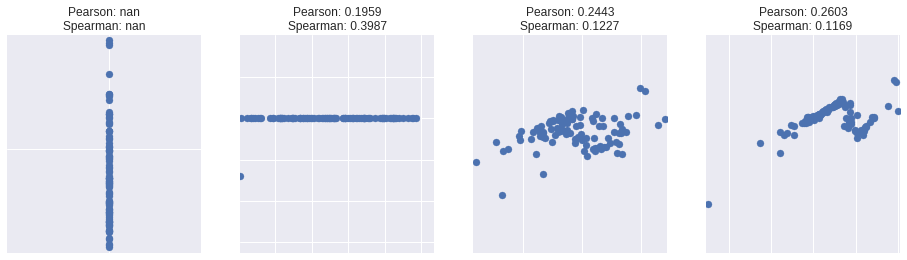

In [282]:
compare_to_truth(data_100, param_100_mosek)

#### 1000 seq

In [296]:
prob_1000, param_1000 = get_convex_model(data=data)

In [ ]:
run_solver(prob=prob_1000)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 131000
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 66000, constraints m = 193001
Cones:	primal zero / dual free vars: 1
	linear vars: 4000
	exp vars: 189000, dual exp vars: 0
Setup time: 4.70e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.36e+21  3.67e+22  1.00e+00 -6.41e+28  1.60e+29  1.38e+29  8.03e-01 
   100| 1.76e-01  1.55e-01  4.50e-03  1.05e+07  1.06e+07  1.34e-08  5.80e+01 


/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

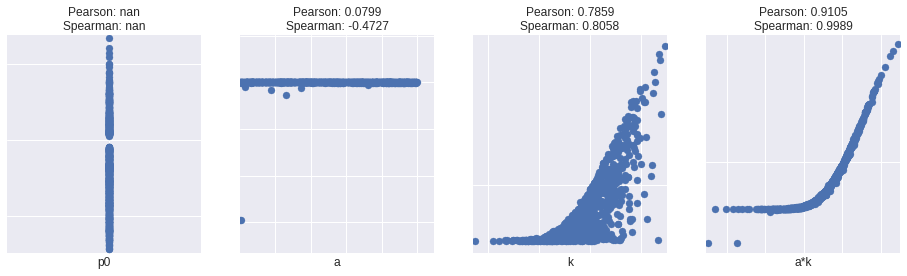

In [299]:
compare_to_truth(data, param_1000)

In [293]:
prob_1000_mosek, param_1000_mosek = get_convex_model(data=data)

In [294]:
run_solver(prob=prob_1000_mosek, solver=cp.MOSEK)



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 193001          
  Cones                  : 63000           
  Scalar variables       : 255000          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 193001          
  Cones                  : 63000           
  Scalar variables       : 255000          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 18000
Optimizer  - Cones                  : 63001
Optimizer  - Scalar var

/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/k-seq/lib/pyt

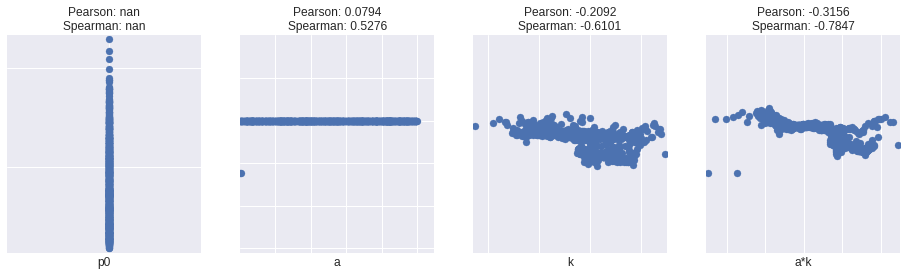

In [295]:
compare_to_truth(data, param_1000_mosek)

## Other results

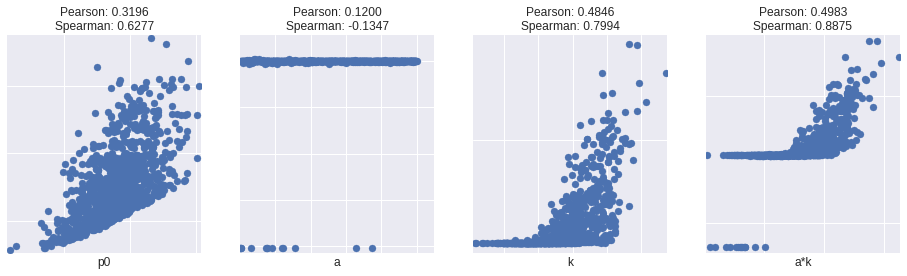

In [40]:
from k_seq.estimator import count_model_mle_cvxpy
reload(count_model_mle_cvxpy)

data_path = '/mnt/storage/projects/k-seq/datasets/simulated/dist_small_uneven_deep/'
results_path = '/mnt/storage/projects/k-seq/working/count_model_mle/dist_small_uneven_deep/'

import pickle

data = count_model_mle_cvxpy.CountData.from_simu_path(path=data_path)
with open(results_path + '/parameters.pkl', 'rb') as handle:
    results = pickle.load(handle)

compare_to_truth(data=data, params=results)

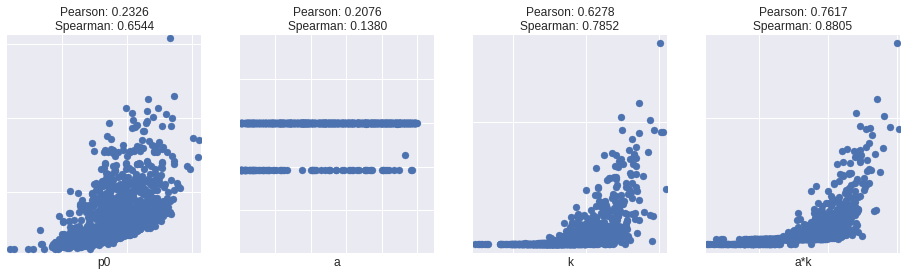

In [41]:
data_path = '/mnt/storage/projects/k-seq/datasets/simulated/dist_small_uneven_shallow/'
results_path = '/mnt/storage/projects/k-seq/working/count_model_mle/dist_small_uneven_shallow/'

import pickle

data = count_model_mle_cvxpy.CountData.from_simu_path(path=data_path)
with open(results_path + '/parameters.pkl', 'rb') as handle:
    results = pickle.load(handle)

compare_to_truth(data=data, params=results)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning

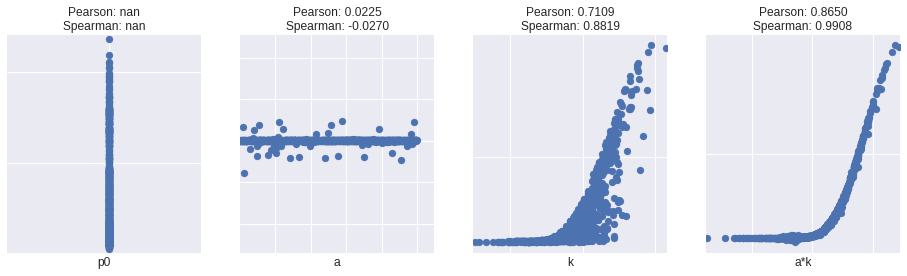

In [42]:
data_path = '/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_deep/'
results_path = '/mnt/storage/projects/k-seq/working/count_model_mle/dist_small_even_deep_scs/'

import pickle

data = count_model_mle_cvxpy.CountData.from_simu_path(path=data_path)
with open(results_path + '/parameters.pkl', 'rb') as handle:
    results = pickle.load(handle)

compare_to_truth(data=data, params=results)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/yuning/.pyenv/versions/anaconda3-5.0.1/envs/k-seq/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning

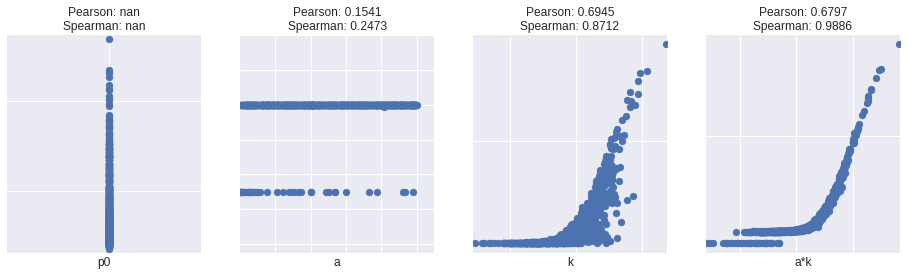

In [43]:
data_path = '/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_shallow/'
results_path = '/mnt/storage/projects/k-seq/working/count_model_mle/dist_small_even_shallow/'

import pickle

data = count_model_mle_cvxpy.CountData.from_simu_path(path=data_path)
with open(results_path + '/parameters.pkl', 'rb') as handle:
    results = pickle.load(handle)

compare_to_truth(data=data, params=results)

In [19]:
def compare_to_truth(data, params, **kwargs):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')
    fig, axes = plt.subplots(1, 4, figsize=[16, 4])
    
    def scale_free_plot(x, y, ax, log=False, label=None, **kwargs):
        from scipy import stats
        
        x_lim = np.min(x) * 0.9, np.max(x) * 1.1
        y_lim = np.min(y) * 0.9, np.max(y) * 1.1
        ax.scatter(x, y, marker='.', alpha=0.8, **kwargs)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        if log:
            ax.set_xscale('log')
            ax.set_yscale('log')
        from scipy.stats import pearsonr, spearmanr
        pearson = pearsonr(x=x, y=y)
        spearman = spearmanr(a=x, b=y)
        ax.set_title(f"Pearson r: {pearson[0]:.4f} (p-val={pearson[1]:.4f})\n"
                 f"Spearman r: {spearman.correlation:.4f} (p-val={spearman.pvalue:.4f})", fontsize=10)
        ax.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
        if label is not None:
            ax.set_xlabel(label, fontsize=12)
    
    scale_free_plot(x=data.truth['p0'], y=params['p0'], ax=axes[0], log=True, label='p0', **kwargs)
    scale_free_plot(x=data.truth['A'], y=params['a'], ax=axes[1], log=False, label='a', **kwargs)
    scale_free_plot(x=data.truth['k'], y=params['k'], ax=axes[2], log=True, label='k',**kwargs)
    scale_free_plot(x=data.truth['k'] * data.truth['A'], 
                    y=params['a'] * params['k'],
                    ax=axes[3], log=True, label='a*k', **kwargs)

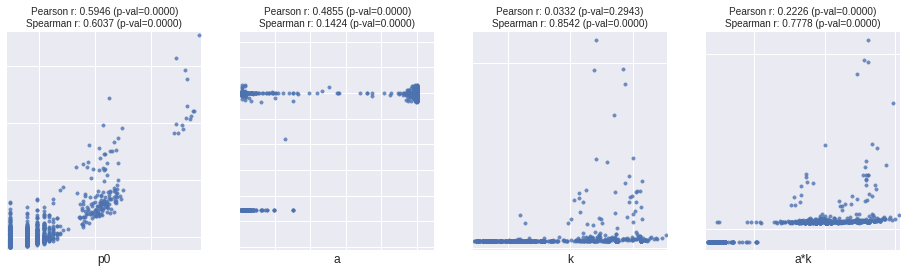

In [20]:
import matplotlib.pyplot as plt
save_fig_to = '/mnt/storage/projects/k-seq/output/2019-11-21_RU_figs/mle_count-model_cvxpy.jpeg'

data_path = '/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s1000_d40/'
results_path = '/mnt/storage/projects/k-seq/working/simu_data/count_model_mle/cvxpy_scs/on_doped_s1000_d40/'

import pickle
from k_seq.estimator import count_model_mle_cvxpy

data = count_model_mle_cvxpy.CountData.from_simu_path(path=data_path)
with open(results_path + '/parameters.pkl', 'rb') as handle:
    results = pickle.load(handle)

compare_to_truth(data=data, params=results)

if save_fig_to:
    fig = plt.gcf()
    fig.patch.set_alpha(0)
    fig.savefig(save_fig_to, bbox_inches='tight', dpi=300)


## non-matrix model

In [148]:

# (J, m) = n.shape

# # Variables.
# P = cp.Variable(J, m)


# # Loss.
# loss = cp.sum_entries(cp.mul_elemwise(n, cp.log(P)))
# # s = 0
# # for j in range(J):
# #     for i in range(m):
# #         s += n[j, i] * cp.log(P[j, i])
# # loss = s
# objective = cp.Maximize(loss)

# # Constraints.
# constraints = (
#     [0 <= P,
#      cp.sum_entries(P, axis=0) == 1]) # np.ones((1, 18))])

# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# res = prob.solve(cp.MOSEK)

array([     nan,      nan,      nan, 2.00e-06, 2.00e-06, 2.00e-06,
       1.00e-05, 1.00e-05, 1.00e-05, 5.00e-05, 5.00e-05, 5.00e-05,
       2.50e-04, 2.50e-04, 2.50e-04, 1.25e-03, 1.25e-03, 1.25e-03])

In [149]:
# (J, m) = n.shape

# # Variables.
# P = cp.Variable(J, m)


# # Loss.
# loss = cp.sum_entries(cp.mul_elemwise(n, cp.log(P)))
# # s = 0
# # for j in range(J):
# #     for i in range(m):
# #         s += n[j, i] * cp.log(P[j, i])
# # loss = s
# objective = cp.Maximize(loss)

# # Constraints.
# constraints = (
#     [0 <= P,
#      cp.sum_entries(P, axis=0) == 1]) # np.ones((1, 18))])

# # Problem.
# prob = cp.Problem(objective, constraints)

# # Solving the problem.
# res = prob.solve(cp.MOSEK)

In [ ]:
with Timer():
    (J, m) = n.shape

    # Variables.
    p0 = cp.Variable(1, m)
    a = cp.Variable(1, m)
    k = cp.Variable(1, m)
    t = 90 * 0.476

    # LL.
    ll = 0
    for j in range(J):
    #     denomj = 0
    #     for q in range(m):
    #         denomj += p0[q] * a[q] * (1 - cp.exp(-k[q] * t * c[j]))
        for i in range(m):
            if np.isnan(c[j]):
                ll += n[j, i] * cp.log(p0[i])
            else:
                ll += n[j, i] * (cp.log(p0[i]) + cp.log(a[i]) + cp.log(1 - cp.exp(-k[i] * t * c[j])))  # - cp.log(denomj))
    objective = cp.Maximize(ll)

    # Constraints.
    constraints = (
        [0 <= p0,
         cp.sum_entries(p0) == 1])

    # Problem.
    prob = cp.Problem(objective, constraints)

    # Solving the problem.
    res = prob.solve(cp.SCS)

WARN: A->p (column pointers) not strictly increasing, column 1306 empty
WARN: A->p (column pointers) not strictly increasing, column 1789 empty
WARN: A->p (column pointers) not strictly increasing, column 2306 empty
WARN: A->p (column pointers) not strictly increasing, column 2789 empty


In [ ]:
np.sum(p0.value)

In [ ]:
plt.plot(np.array(k.value).squeeze());

In [ ]:
plt.plot(truth.k);

In [ ]:
stats.pearsonr(np.array(k.value).squeeze(), truth.k)

In [11]:
# c = np.ones(J)

In [55]:
# (J, m) = n.shape

# # Variables.
# p0 = cp.Variable(1, m)
# a = cp.Variable(1, m)
# k = cp.Variable(1, m)
# t = 90 * 0.476

# # Loss.
# # P = cp.vstack([cp.log(p0) + cp.log(a) + cp.log(1-cp.exp(-k*t*c)) for i in range(J)])
# s = 0
# for j in range(J):
#     for i in range(m):
#         s += n[j, i] * (cp.log(p0[i]) + cp.log(a[i]) + cp.log(1 - cp.exp(-k[i] * t * c[j])))
# # ll = cp.sum_entries(cp.mul_elemwise(n, P))
# ll = s
# objective = cp.Maximize(ll)

# # # Constraints.
# # constraints = (
# #     [0 <= P,
# #      cp.sum_entries(P, axis=0) == 1]) # np.ones((1, 18))])

# # Problem.
# prob = cp.Problem(objective)

# # Solving the problem.
# res = prob.solve(cp.SCS)

In [56]:
# res

29419960.153901663

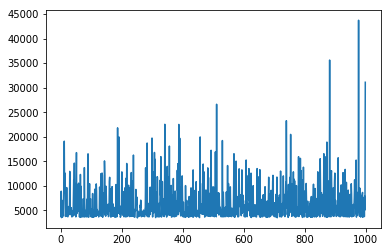

In [72]:
# plt.plot(p0.value.T);

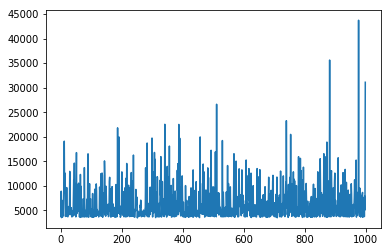

In [73]:
# plt.plot(a.value.T);

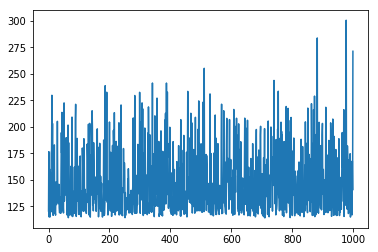

In [74]:
# plt.plot(k.value.T);

# Swapping variables with exp

In [111]:
# # (J, m) = n.shape
# m = 20

# # Variables.
# p0p = cp.Variable(1, m)
# ap = cp.Variable(1, m)
# k = cp.Variable(1, m)
# t = 90 * 0.476

# # LL.
# ll = 0
# for j in range(J):
#     denomj = 0
#     for q in range(m):
#         denomj += (cp.exp(p0p[q] + ap[q]) - cp.exp(p0p[q] + ap[q] - k[q] * t * c[j]))
#     for i in range(m):
#         if np.isnan(c[j]):
#             ll += n[j, i] * p0p[i]
#         else:
#             ll += n[j, i] * (
#                 cp.log(cp.exp(p0p[i] + ap[i]) - cp.exp(p0p[i] + ap[i] - k[i] * t * c[j])) - cp.log(denomj))
# objective = cp.Maximize(ll)

# # # Constraints.
# # constraints = (
# #     [0 <= p0p,
# #      cp.sum_entries(p0) == 1])

# # Problem.
# prob = cp.Problem(objective)  #, constraints)

# # Solving the problem.
# res = prob.solve(cp.MOSEK)

DCPError: Problem does not follow DCP rules.